# Technical Details

In [1]:
# Dependencies
from typing import List, Tuple, Dict
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx

import torch 
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric as pyg

import pygmtools as pygm
pygm.set_backend('pytorch')

import D4Explainer

c:\Users\Admin\anaconda3\envs\SuperTest2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Meta Data

# Reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True 
np.random.seed(SEED)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Variables. 
max_num_nodes = 30 # 28 in the full dataset.  
batch_size = 64
color_palette = np.array(['orange', 'magenta', 'green', 'blue', 'cyan', 'red', 'lime'])

Using device: cuda


## MUTAG Data  

In [3]:
# Download data. 
from torch_geometric.datasets import TUDataset
data_raw = TUDataset(root='data/TUDataset', name='MUTAG')

# Shuffle.
data_raw = data_raw.shuffle()

# Split.
train_data = data_raw[:150]
test_data = data_raw[150:]

def preprocess_MUTAG(data: TUDataset, max_num_nodes) -> pyg.data.Data:
    
    num_nodes = data.num_nodes
    
    # Pad node features.
    padded_x = torch.zeros((max_num_nodes, data.x.size(1)))
    padded_x[:num_nodes] = data.x

    # Relax edges to weights. 
    padded_adj = torch.zeros((max_num_nodes, max_num_nodes))
    padded_adj[:num_nodes, :num_nodes] = (
        pyg.utils.to_dense_adj(data.edge_index).squeeze(0)
    )
    edge_index, edge_weight = pygm.utils.dense_to_sparse(padded_adj + 1)
    edge_index = edge_index.transpose(0, 1)
    edge_weight = edge_weight.squeeze(0)

    # Wrap in data object.
    preprocessed_data = pyg.data.Data(x=padded_x, 
                                      edge_index=edge_index,
                                      edge_attr=edge_weight - 1,
                                      y=data.y)

    return preprocessed_data 

# Create data lists.
train_data_list = []
train_data_list_0 = []
train_data_list_1 = []
test_data_list = []
test_data_list_0 = []
test_data_list_1 = []

for graph in train_data:
    train_data_list.append(preprocess_MUTAG(graph, max_num_nodes))

    if graph.y.item() == 0: 
        train_data_list_0.append(preprocess_MUTAG(graph, max_num_nodes))

    elif graph.y.item() == 1: 
        train_data_list_1.append(preprocess_MUTAG(graph, max_num_nodes))

for graph in test_data:
    test_data_list.append(preprocess_MUTAG(graph, max_num_nodes))

    if graph.y.item() == 0: 
        test_data_list_0.append(preprocess_MUTAG(graph, max_num_nodes))

    elif graph.y.item() == 1: 
        test_data_list_1.append(preprocess_MUTAG(graph, max_num_nodes))

# Create data loaders.
train_loader = pyg.loader.DataLoader(train_data_list, batch_size=batch_size, 
                                     shuffle=True)
test_loader = pyg.loader.DataLoader(test_data_list, batch_size=batch_size, 
                                    shuffle=True)

In [4]:
def clean_graph(gen: pyg.data.Data) -> pyg.data.Data: 
    """
    Removes self loops and isolated nodes. 
    """
    edge_index = gen.edge_index

    edge_index, edge_attr = pyg.utils.remove_self_loops(edge_index)

    edge_index, edge_attr, mask = (
        pyg.utils.remove_isolated_nodes(edge_index, num_nodes=gen.x.shape[0])
    )

    # Zero node features if all cleared. 
    if gen.x[mask].shape[0] == 0:
        x = gen.x * 0.0
    else: 
        x = gen.x[mask]

    cleaned = pyg.data.Data(
        x = x, 
        edge_index = edge_index, 
    )

    return cleaned

def graph_to_nx(graph: pyg.data.Batch) -> nx.Graph:
    
    graph.edge_index = pygm.utils.dense_to_sparse(
        graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    graph = clean_graph(graph)
    graph_colors = color_palette[torch.argmax(graph.x, dim=1)]
    graph_nx = pyg.utils.to_networkx(graph)

    return graph_nx

## Explainee GCN Model

In [5]:
class GCNWeighted(nn.Module):
    def __init__(self, hidden_channels):
        super(GCNWeighted, self).__init__()
        self.conv1 = pyg.nn.GCNConv(7, hidden_channels) # 7 node features.
        self.conv2 = pyg.nn.GCNConv(hidden_channels, hidden_channels)
        self.conv3 = pyg.nn.GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 2) # 2 classes.
    
    def forward(self, data):
        x, edge_index, batch, edge_weight = (
            data.x, data.edge_index, data.batch, data.edge_attr
        )

        # 1. Node embeddings.
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Pooling.
        x = pyg.nn.global_mean_pool(x, batch)

        # 3. Prediction.
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [6]:
# Training Explainee.
explainee = GCNWeighted(hidden_channels=64)
optimizer = torch.optim.Adam(explainee.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(data_loader): 
    explainee.train()

    for batch in data_loader: 
        out = explainee(batch)
        loss = criterion(out, batch.y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

def explainee_accuracy(data_loader):
    explainee.eval()

    correct = 0
    for batch in data_loader: 
        out = explainee(batch)
        pred = out.argmax(dim=1)
        correct += int((pred == batch.y).sum())

    return correct / len(data_loader.dataset)

for epoch in range(1, 201): 
    train(train_loader)
    train_accuracy = explainee_accuracy(train_loader)
    test_accuracy = explainee_accuracy(test_loader)

    print(f"Epoch: {epoch} Train Accuracy: {train_accuracy} " + 
          f"Test Accuracy: {test_accuracy}")

Epoch: 1 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 2 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 3 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 4 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 5 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 6 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 7 Train Accuracy: 0.68 Test Accuracy: 0.7105263157894737
Epoch: 8 Train Accuracy: 0.7066666666666667 Test Accuracy: 0.7631578947368421
Epoch: 9 Train Accuracy: 0.7133333333333334 Test Accuracy: 0.7631578947368421
Epoch: 10 Train Accuracy: 0.7333333333333333 Test Accuracy: 0.8157894736842105
Epoch: 11 Train Accuracy: 0.82 Test Accuracy: 0.8421052631578947
Epoch: 12 Train Accuracy: 0.82 Test Accuracy: 0.8421052631578947
Epoch: 13 Train Accuracy: 0.78 Test Accuracy: 0.8421052631578947
Epoch: 14 Train Accuracy: 0.8266666666

In [7]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

full_batch = pyg.data.Batch.from_data_list(test_data_list + train_data_list)
explainee.eval()
preds = explainee(full_batch).argmax(dim=1).numpy()
targets = full_batch.y.numpy()

conf_matrix = confusion_matrix(targets, preds)
conf_matrix

array([[ 46,  17],
       [ 10, 115]], dtype=int64)

## D4Explainer 

In [8]:
# Hyperparameters.
T = 50
time_embed_dim = 10
num_node_feats = 7

betas = torch.linspace(start=0.001, end=0.1, steps=T)
beta_bars = []
cum_prod = 1

for beta in betas:
    cum_prod *= (1 - 2*beta)
    beta_bars.append(0.5 - 0.5 * cum_prod)

num_epochs = 200

In [9]:
def forward_diffusion_sample(graphs: pyg.data.Batch, 
                             t: int) -> pyg.data.Batch:
    """
    Input: Batch of observed graphs.
    Output: Batch of noised graphs.
    """
    edge_weight = graphs.edge_attr

    transition_probs = torch.full_like(edge_weight, beta_bars[t])
    transition_dist = torch.distributions.RelaxedBernoulli(
        temperature=0.15, probs=transition_probs
    )

    noised_edge_weights = torch.abs(
        edge_weight + transition_dist.rsample()
    )
    noised_graph = pyg.data.Batch(x=graphs.x, 
                                  edge_index=graphs.edge_index,
                                  edge_attr=noised_edge_weights,  
                                  y=graphs.y, batch=graphs.batch)

    return noised_graph

In [10]:
class denoising_model(nn.Module):
    def __init__(self, T, time_embed_dim, 
                 num_node_feats, h1=10, h2=50, h3=30, p_dropout=0.5): 
        super(denoising_model, self).__init__()

        self.time_embedder = nn.Embedding(num_embeddings=T, 
                                          embedding_dim=time_embed_dim) 

        self.conv1 = pyg.nn.GCNConv(num_node_feats, h1)
        self.conv2 = pyg.nn.GCNConv(h1, h2)
        self.conv3 = pyg.nn.GCNConv(h2, h3)

        self.p_dropout = p_dropout
        self.lin = nn.Linear(h3, max_num_nodes**2) # predicting weights.

    def forward(self, noised_graphs, t):
        
        x, edge_index, batch, edge_weight = (
            noised_graphs.x, noised_graphs.edge_index, 
            noised_graphs.batch, noised_graphs.edge_weight
        )

        time_embedding = self.time_embedder(t)

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.p_dropout)
        
        x = x + time_embedding
        
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.p_dropout)

        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.p_dropout)

        x = pyg.nn.global_mean_pool(x, batch)
        x = F.dropout(x, p=self.p_dropout)
        x = self.lin(x)
        x = F.sigmoid(x) 

        pred_weights = x.reshape(-1)
        pred_graph = pyg.data.Batch(x=noised_graphs.x, 
                                    edge_index=noised_graphs.edge_index,
                                    edge_attr=pred_weights,
                                    batch=noised_graphs.batch)
    
        return [pred_weights, pred_graph]

In [55]:
# Training Loop.
model_denoise= denoising_model(T, time_embed_dim=time_embed_dim, 
                                num_node_feats=num_node_feats) 

optimizer = torch.optim.Adam(model_denoise.parameters(), lr=0.001)
CF_weight = 0.0

for epoch in range(1, num_epochs): 
    running_loss_dist = 0.0
    running_loss_CF = 0.0
    for graphs in train_loader:
        with torch.no_grad():
            t = torch.randint(low=1, high=T, size=(1,))
            noised_graphs = forward_diffusion_sample(graphs, t)

        pred_weight, pred_graph = model_denoise(noised_graphs, t)

        loss_dist = F.binary_cross_entropy(
            pred_weight, graphs.edge_attr.squeeze(1)
        )  
        running_loss_dist += loss_dist.item()

        explainee.eval()
        explainee_pred = F.softmax(explainee(pred_graph), dim=-1)
        class_prob = explainee_pred[torch.arange(explainee_pred.shape[0]), 
                                    graphs.y]
        loss_CF = (-1 * torch.log(1 - class_prob)).mean()
        running_loss_CF += loss_CF.item()

        loss = 1.0 * loss_dist + CF_weight * loss_CF
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(
        f"Epoch: {epoch}", 
        f" Loss_dist: {running_loss_dist / len(train_loader)}", 
        f" Loss_CF: {running_loss_CF / len(train_loader)}"
    )

Epoch: 1  Loss_dist: 0.7045539816220602  Loss_CF: 1.8936461607615154
Epoch: 2  Loss_dist: 0.6937039097150167  Loss_CF: 1.8981842994689941
Epoch: 3  Loss_dist: 0.6914013226826986  Loss_CF: 1.7943708499272664
Epoch: 4  Loss_dist: 0.684727946917216  Loss_CF: 1.7868639628092449
Epoch: 5  Loss_dist: 0.670720378557841  Loss_CF: 1.7892645994822185
Epoch: 6  Loss_dist: 0.6659600933392843  Loss_CF: 1.8417359590530396
Epoch: 7  Loss_dist: 0.6631307601928711  Loss_CF: 1.75698717435201
Epoch: 8  Loss_dist: 0.6386498212814331  Loss_CF: 1.7799574931462605
Epoch: 9  Loss_dist: 0.6389240423838297  Loss_CF: 1.8219621578852336
Epoch: 10  Loss_dist: 0.6391758521397909  Loss_CF: 1.8101502656936646
Epoch: 11  Loss_dist: 0.608316977818807  Loss_CF: 1.7540945609410603
Epoch: 12  Loss_dist: 0.6207579175631205  Loss_CF: 1.8265836238861084
Epoch: 13  Loss_dist: 0.5863385200500488  Loss_CF: 1.8030062516530354
Epoch: 14  Loss_dist: 0.5645477970441183  Loss_CF: 1.7580493688583374
Epoch: 15  Loss_dist: 0.5417495667

In [136]:
def model_level_sampling(N: int, K:int, target: int):
    # Sample random adjacency matrix.
    rand_weight = torch.zeros((K, max_num_nodes, max_num_nodes))
    for batch in range(K):
        idx = [(i, j) for i in range(max_num_nodes) for j in range(max_num_nodes)]
        rand_idx = torch.randperm(len(idx))[:N**2]
        for i in rand_idx:
            i, j = idx[i]
            rand_weight[batch, i, j] = 0.5
    Gr_T = torch.bernoulli(rand_weight).view(-1, 1).squeeze(-1)

    # Combine with observed node features.
    features = pyg.data.Batch.from_data_list(
        test_data_list[:K]
    )
    Gr_T = pyg.data.Data(
        x=features.x, edge_index=features.edge_index, edge_attr=Gr_T, 
        batch=features.batch
    )

    for t in range(T-1, 0, -1):
        # Sample candidates.
        pred_weight, G0_K = model_denoise(Gr_T, torch.tensor([t]))
        # Compute probabilities. 
        probs = F.softmax(explainee(G0_K), dim=-1)[:, target]
        j = torch.argmax(probs)
        pred_weight = pred_weight.reshape(K, max_num_nodes, max_num_nodes)
        G0_j = torch.bernoulli(pred_weight[j, :, :]).view(-1, 1).squeeze(-1)
        G0_j = pyg.data.Batch(
            x=features.x, edge_index=features.edge_index, 
            edge_attr=G0_j.repeat(K), 
            batch=features.batch
        )

        Gr_T = forward_diffusion_sample(G0_j, torch.tensor([t-1]))
    
    return Gr_T
        

In [140]:
Gr_0 = model_level_sampling(30, 30, 0)
F.softmax(explainee(Gr_0), dim=-1)

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], grad_fn=<SoftmaxBackward0>)

## Counter-Factual

In [43]:
# Training Loop.
model_denoise_CF = denoising_model(T, time_embed_dim=time_embed_dim, 
                                num_node_feats=num_node_feats) 

optimizer = torch.optim.Adam(model_denoise_CF.parameters(), lr=0.001)
CF_weight = 0.0

for epoch in range(1, num_epochs): 
    running_loss_dist = 0.0
    running_loss_CF = 0.0
    for graphs in train_loader:
        with torch.no_grad():
            t = torch.randint(low=1, high=T, size=(1,))
            noised_graphs = forward_diffusion_sample(graphs, t)

        pred_weight, pred_graph = model_denoise_CF(noised_graphs, t)

        loss_dist = F.binary_cross_entropy(
            pred_weight, graphs.edge_attr.squeeze(1)
        )  
        running_loss_dist += loss_dist.item()

        explainee.eval()
        explainee_pred = F.softmax(explainee(pred_graph), dim=-1)
        class_prob = explainee_pred[torch.arange(explainee_pred.shape[0]), 
                                    graphs.y]
        loss_CF = (-1 * torch.log(1 - class_prob)).mean()
        running_loss_CF += loss_CF.item()

        loss = 1.0 * loss_dist + CF_weight * loss_CF
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(
        f"Epoch: {epoch}", 
        f" Loss_dist: {running_loss_dist / len(train_loader)}", 
        f" Loss_CF: {running_loss_CF / len(train_loader)}"
    )

Epoch: 1  Loss_dist: 0.7103374401728312  Loss_CF: 1.8020889361699421
Epoch: 2  Loss_dist: 0.6981330513954163  Loss_CF: 1.7202640374501545
Epoch: 3  Loss_dist: 0.6866494615872701  Loss_CF: 1.8047802050908406
Epoch: 4  Loss_dist: 0.6817629535992941  Loss_CF: 1.8511871099472046
Epoch: 5  Loss_dist: 0.672788163026174  Loss_CF: 1.8070756594340007
Epoch: 6  Loss_dist: 0.6724409262339274  Loss_CF: 1.7919286489486694
Epoch: 7  Loss_dist: 0.6624539693196615  Loss_CF: 1.6639485359191895
Epoch: 8  Loss_dist: 0.6594754656155905  Loss_CF: 1.8453912734985352
Epoch: 9  Loss_dist: 0.6467503706614176  Loss_CF: 1.7588924169540405
Epoch: 10  Loss_dist: 0.6384918888409933  Loss_CF: 1.76357368628184
Epoch: 11  Loss_dist: 0.6131114562352499  Loss_CF: 1.7686378161112468
Epoch: 12  Loss_dist: 0.6103530327479044  Loss_CF: 1.6632742484410603
Epoch: 13  Loss_dist: 0.5976823767026266  Loss_CF: 1.7864468097686768
Epoch: 14  Loss_dist: 0.6072963078816732  Loss_CF: 1.7426691850026448
Epoch: 15  Loss_dist: 0.57158678

In [44]:
# Figure 4 on page 8.

# CF-ACC
test_batch = pyg.data.Batch.from_data_list(test_data_list)
preds_on_obs = torch.argmax(explainee(test_batch), dim=-1)

noised_graphs = forward_diffusion_sample(test_batch, torch.tensor([T-1]))
_, pred_graph = model_denoise_CF(noised_graphs, torch.tensor([T-1]))
pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
preds_on_CF = torch.argmax(explainee(pred_graph), dim=-1)

CF_ACC = (preds_on_CF != preds_on_obs).sum() / len(test_data_list)
print(f"CF-ACC: {CF_ACC}")

CF-ACC: 0.18421052396297455


tensor([[0.7762, 0.2238]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0617, 0.9383]], grad_fn=<SoftmaxBackward0>)


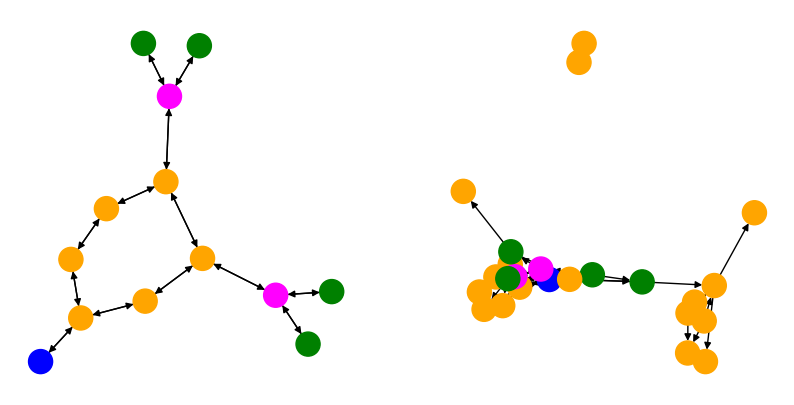

In [46]:
# Like figure 5 on page 9.

test_graph_0 = pyg.data.Batch.from_data_list([test_data_list_0[0]])
print(torch.softmax(explainee(test_graph_0), dim=-1))

noised_graph = forward_diffusion_sample(test_graph_0, torch.tensor([T-1])) 
_, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
print(torch.softmax(explainee(pred_graph), dim=-1))
pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)

test_graph_0.edge_index = pygm.utils.dense_to_sparse(
    test_graph_0.edge_attr.reshape(max_num_nodes, max_num_nodes)
)[0].transpose(0, 1)
test_graph_0 = clean_graph(test_graph_0)
test_graph_0_colors = color_palette[torch.argmax(test_graph_0.x, dim=1)]
test_graph_0_nx = pyg.utils.to_networkx(test_graph_0)

pred_graph.edge_index = pygm.utils.dense_to_sparse(
    pred_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
)[0].transpose(0, 1)
pred_graph = clean_graph(pred_graph)
pred_graph_colors = color_palette[torch.argmax(pred_graph.x, dim=1)]
pred_graph_nx = pyg.utils.to_networkx(pred_graph)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
nx.draw(test_graph_0_nx, node_color=test_graph_0_colors, ax=axes[0])
nx.draw(pred_graph_nx, node_color=pred_graph_colors, ax=axes[1])

tensor([[0.0362, 0.9638]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0154, 0.9846]], grad_fn=<SoftmaxBackward0>)


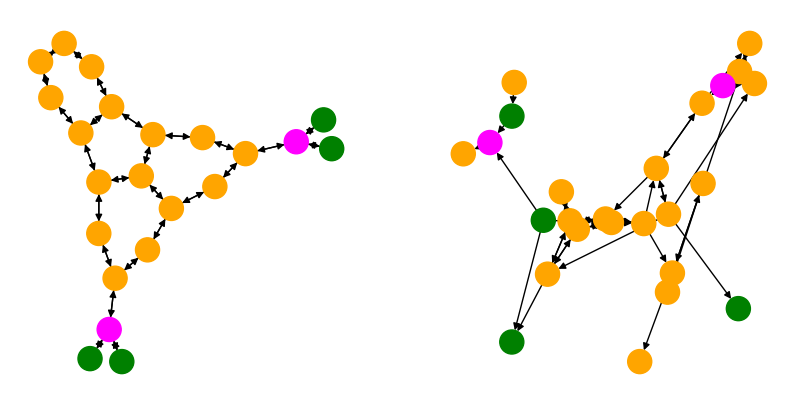

In [52]:
# Like figure 5 on page 9.

test_graph_1 = pyg.data.Batch.from_data_list([test_data_list_1[5]])
print(torch.softmax(explainee(test_graph_1), dim=-1))

noised_graph = forward_diffusion_sample(test_graph_1, torch.tensor([T-1])) 
_, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
print(torch.softmax(explainee(pred_graph), dim=-1))
pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)

test_graph_1.edge_index = pygm.utils.dense_to_sparse(
    test_graph_1.edge_attr.reshape(max_num_nodes, max_num_nodes)
)[0].transpose(0, 1)
test_graph_1 = clean_graph(test_graph_1)
test_graph_1_colors = color_palette[torch.argmax(test_graph_1.x, dim=1)]
test_graph_1_nx = pyg.utils.to_networkx(test_graph_1)

pred_graph.edge_index = pygm.utils.dense_to_sparse(
    pred_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
)[0].transpose(0, 1)
pred_graph = clean_graph(pred_graph)
pred_graph_colors = color_palette[torch.argmax(pred_graph.x, dim=1)]
pred_graph_nx = pyg.utils.to_networkx(pred_graph)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
nx.draw(test_graph_1_nx, node_color=test_graph_1_colors, ax=axes[0])
nx.draw(pred_graph_nx, node_color=pred_graph_colors, ax=axes[1])

In [53]:
# Table 2 on page 8.

graph_ref_list_0 = []
for graph in train_data_list_0:
    graph_ref = pyg.data.Batch.from_data_list([graph])
    graph_ref = graph_to_nx(graph_ref)
    graph_ref = graph_ref.to_undirected()
    graph_ref_list_0.append(graph_ref)

graph_pred_list_0 = []
for graph in train_data_list_1:
    noised_graph = forward_diffusion_sample(graph, torch.tensor([T-1])) 
    _, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
    pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
    pred_graph = graph_to_nx(pred_graph)
    pred_graph = pred_graph.to_undirected()
    graph_pred_list_0.append(pred_graph)

deg_mmd_0 = D4Explainer.degree_stats(
    graph_ref_list_0, graph_pred_list_0
)

clus_mmd_0 = D4Explainer.clustering_stats(
    graph_ref_list_0, graph_pred_list_0
)

spec_mmd_0 = D4Explainer.spectral_stats(
   graph_ref_list_0, graph_pred_list_0 
)

print(f"deg_mmd_0: {deg_mmd_0}")
print(f"clus_mmd_0: {clus_mmd_0}")
print(f"spec_mmd_0: {spec_mmd_0}")

deg_mmd_0: 0.2902112401083605
clus_mmd_0: 0.6553487940553064
spec_mmd_0: 0.047913099714195946


In [54]:
# Table 2 on page 8.

graph_ref_list_1 = []
for graph in train_data_list_1:
    graph_ref = pyg.data.Batch.from_data_list([graph])
    graph_ref = graph_to_nx(graph_ref)
    graph_ref = graph_ref.to_undirected()
    graph_ref_list_1.append(graph_ref)

graph_pred_list_1 = []
for graph in train_data_list_0:
    noised_graph = forward_diffusion_sample(graph, torch.tensor([T-1])) 
    _, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
    pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
    pred_graph = graph_to_nx(pred_graph)
    pred_graph = pred_graph.to_undirected()
    graph_pred_list_1.append(pred_graph)

deg_mmd_1 = D4Explainer.degree_stats(
    graph_ref_list_1, graph_pred_list_1
)

clus_mmd_1 = D4Explainer.clustering_stats(
    graph_ref_list_1, graph_pred_list_1
)

spec_mmd_1 = D4Explainer.spectral_stats(
   graph_ref_list_1, graph_pred_list_1 
)

print(f"deg_mmd_1: {deg_mmd_1}")
print(f"clus_mmd_1: {clus_mmd_1}")
print(f"spec_mmd_1: {spec_mmd_1}")

deg_mmd_1: 0.2896000209175438
clus_mmd_1: 0.816577466399587
spec_mmd_1: 0.040448084604650145


# Debugging